In [3]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [4]:
user = pd.read_csv('Pricing_Test_data/user_table.csv')
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [5]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
user_id    275616 non-null int64
city       275616 non-null object
country    275616 non-null object
lat        275616 non-null float64
long       275616 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 8.4+ MB


In [6]:
test = pd.read_csv('Pricing_Test_data/test_results.csv', parse_dates = ['timestamp'])
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
user_id             316800 non-null int64
timestamp           316800 non-null object
source              316800 non-null object
device              316800 non-null object
operative_system    316800 non-null object
test                316800 non-null int64
price               316800 non-null int64
converted           316800 non-null int64
dtypes: int64(4), object(4)
memory usage: 14.5+ MB


In [9]:
print('user_table:\t', user['user_id'].unique().shape)
print('test_results:\t', test['user_id'].unique().shape)

user_table:	 (275616,)
test_results:	 (316800,)


In [10]:
data = pd.merge(left = user, right = test, how ='right', on = 'user_id')
data.head()

,user_id,city,country,lat,long,timestamp,source,device,operative_system,test,price,converted
0,510335,Peabody,USA,42.53,-70.97,2015-05-02 12:06:41,ads-google,mobile,android,0,39,0
1,89568,Reno,USA,39.54,-119.82,2015-04-30 16:02:01,ads_facebook,mobile,android,1,59,0
2,434134,Rialto,USA,34.11,-117.39,2015-05-16 19:53:40,direct_traffic,web,windows,1,59,0
3,289769,Carson City,USA,39.15,-119.74,2015-04-23 18:50:58,ads_facebook,web,windows,0,39,0
4,939586,Chicago,USA,41.84,-87.68,2015-03-08 13:53:10,ads_facebook,mobile,iOS,1,59,0


In [11]:
data.isnull().sum()

user_id                 0
city                41184
country             41184
lat                 41184
long                41184
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
dtype: int64

In [14]:
#Check if all test results match the price
data[['user_id', 'test','price']].groupby(['test', 'price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

For test = 0, users in control group should see price = 39, 210 wrong rows in the dataset
For test =1, users in experiment group should see price = 59, 155 wrong rows in the dataset 

In [15]:
#Delete all invalid data
data = data[((data['test'] ==0) & (data['price'] == 39)) |
            ((data['test'] ==1) & (data['price'] == 59))]

In [16]:
data['revenue'] = data['converted'] * data['price']

In [17]:
data.head()

,user_id,city,country,lat,long,timestamp,source,device,operative_system,test,price,converted,revenue
0,510335,Peabody,USA,42.53,-70.97,2015-05-02 12:06:41,ads-google,mobile,android,0,39,0,0
1,89568,Reno,USA,39.54,-119.82,2015-04-30 16:02:01,ads_facebook,mobile,android,1,59,0,0
2,434134,Rialto,USA,34.11,-117.39,2015-05-16 19:53:40,direct_traffic,web,windows,1,59,0,0
3,289769,Carson City,USA,39.15,-119.74,2015-04-23 18:50:58,ads_facebook,web,windows,0,39,0,0
4,939586,Chicago,USA,41.84,-87.68,2015-03-08 13:53:10,ads_facebook,mobile,iOS,1,59,0,0


# Visualization

## Source

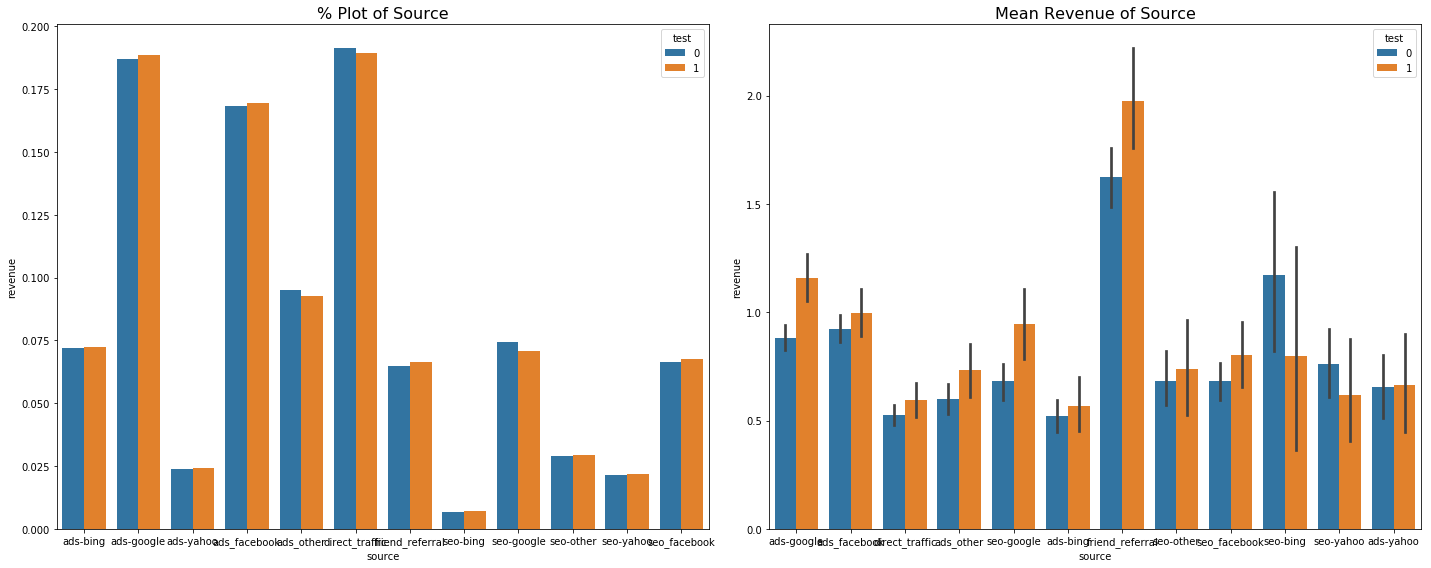

In [23]:
src_grp = data[['source','test','revenue']].groupby(['source', 'test']).count().reset_index()
src_grp.loc[src_grp['test'] == 1, 'revenue'] = src_grp.loc[src_grp['test'] == 1, 'revenue'] / 113918
src_grp.loc[src_grp['test'] == 0, 'revenue'] = src_grp.loc[src_grp['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
sns.barplot(x = 'source', y ='revenue', hue = 'test', data = src_grp, ax = ax[0])
ax[0].set_title('% Plot of Source', fontsize = 16)

sns.barplot(x = 'source', y = 'revenue', hue = 'test', data = data, ax = ax[1])
ax[1].set_title('Mean Revenue of Source', fontsize = 16)

plt.tight_layout()
plt.show()

## Device

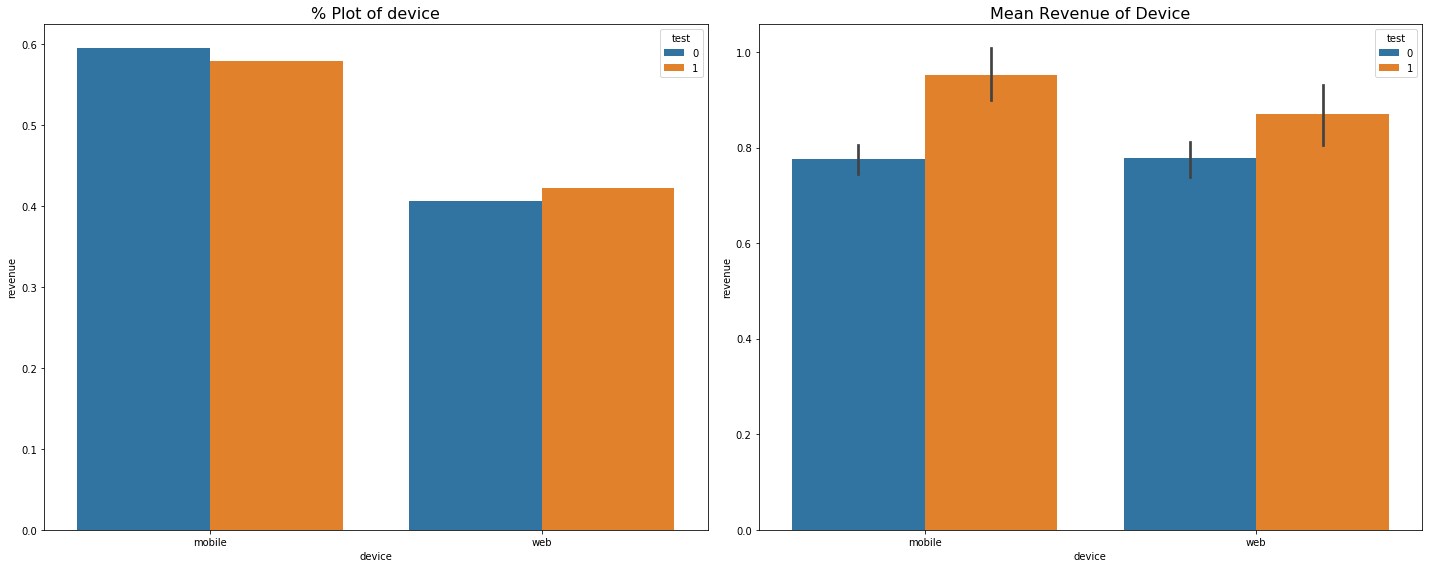

In [25]:
de_grp = data[['device', 'test', 'revenue']].groupby(['device','test']).count().reset_index()
de_grp.loc[de_grp['test'] == 1, 'revenue'] = de_grp.loc[de_grp['test'] == 1, 'revenue'] / 113918
de_grp.loc[de_grp['test'] == 0, 'revenue'] = de_grp.loc[de_grp['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))

sns.barplot(x = 'device', y = 'revenue', data = de_grp, hue = 'test', ax = ax[0])
ax[0].set_title('% Plot of device', fontsize = 16)

sns.barplot(x = 'device', y = 'revenue', data = data, hue = 'test', ax = ax[1])
ax[1].set_title('Mean Revenue of Device', fontsize = 16)

plt.tight_layout()
plt.show()


## OS

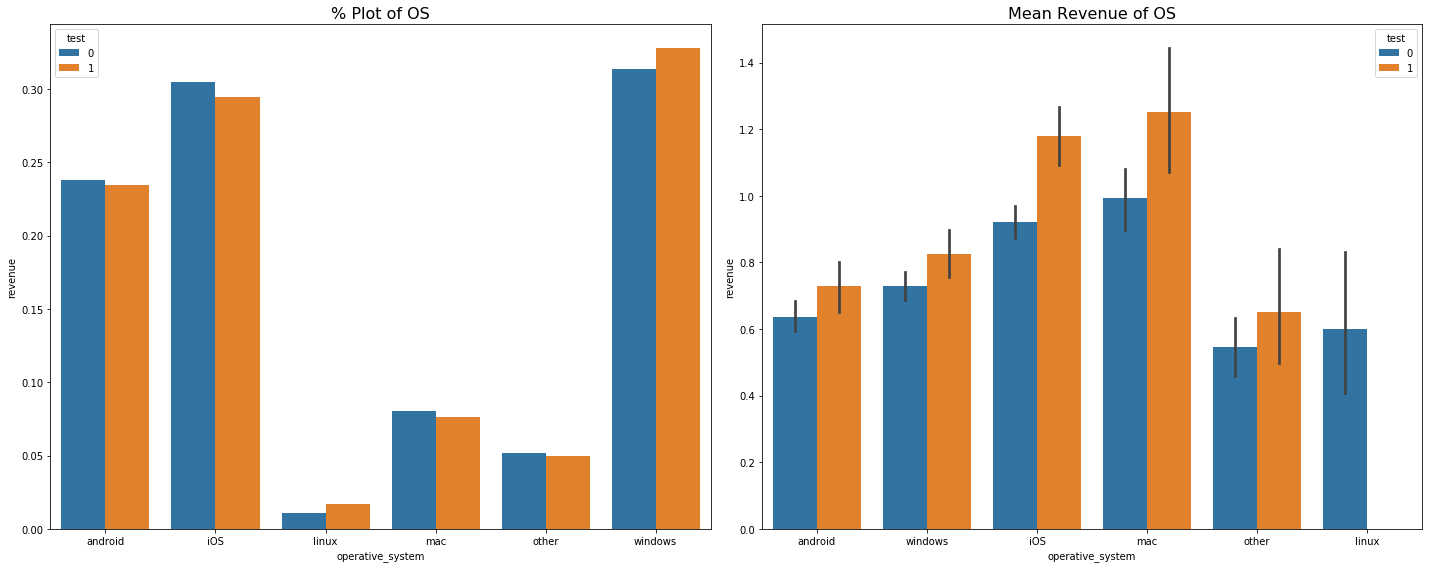

In [27]:
os_grp = data[['operative_system', 'test', 'revenue']].groupby(['operative_system', 'test']).count().reset_index()
os_grp.loc[os_grp['test'] == 1, 'revenue'] = os_grp.loc[os_grp['test'] == 1, 'revenue'] / 113918
os_grp.loc[os_grp['test'] == 0, 'revenue'] = os_grp.loc[os_grp['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))

sns.barplot(x = 'operative_system', y = 'revenue', data = os_grp, hue = 'test', ax = ax[0])
ax[0].set_title('% Plot of OS', fontsize = 16)

sns.barplot(x = 'operative_system', y = 'revenue', data = data, hue = 'test', ax = ax[1])
ax[1].set_title('Mean Revenue of OS', fontsize = 16)
plt.tight_layout()
plt.show()


## Q1: 39 or 59?

In [28]:
data[['test', 'converted']].groupby('test').mean()

,converted
test,
0,0.019900
1,0.015555


In [29]:
data[['test', 'revenue']].groupby('test').sum()

,revenue
test,
0,157170
1,104548


In [30]:
data[['test', 'revenue']].groupby('test').mean()

,revenue
test,
0,0.776083
1,0.917748


lower price, $39 has higher conversion rate but lower average revenue.

Hypothesis testing:

* Null Hypothesis H0: experimental group's average revenue is euqal or less than control's group average revenue.

* Alternative Hypothesis H1: experimental average revenue is higher than control.


In [31]:
exp_val = data[data['test'] == 1]['revenue'].values
ctr_val = data[data['test'] == 0]['revenue'].values
print(ttest_ind(ctr_val, exp_val, axis = 0, equal_var = False))

Ttest_indResult(statistic=-5.715224666463109, pvalue=1.0972577312420708e-08)


P-value is so large that we can reject the null hypothesis though with two tailed result, which means the experimental group with higher price can give us higher revenue.

## Q2: Findings into user behavior vs. CR

### Source

In [49]:
#source
src = data.groupby('source')['converted'].mean().reset_index()
src.sort_values(by = 'converted', ascending = False)

,source,converted
6,friend_referral,0.038688
7,seo-bing,0.023787
1,ads-google,0.021502
3,ads_facebook,0.021198
8,seo-google,0.016978
10,seo-yahoo,0.016226
11,seo_facebook,0.016051
9,seo-other,0.015686
2,ads-yahoo,0.014793
4,ads_other,0.014350


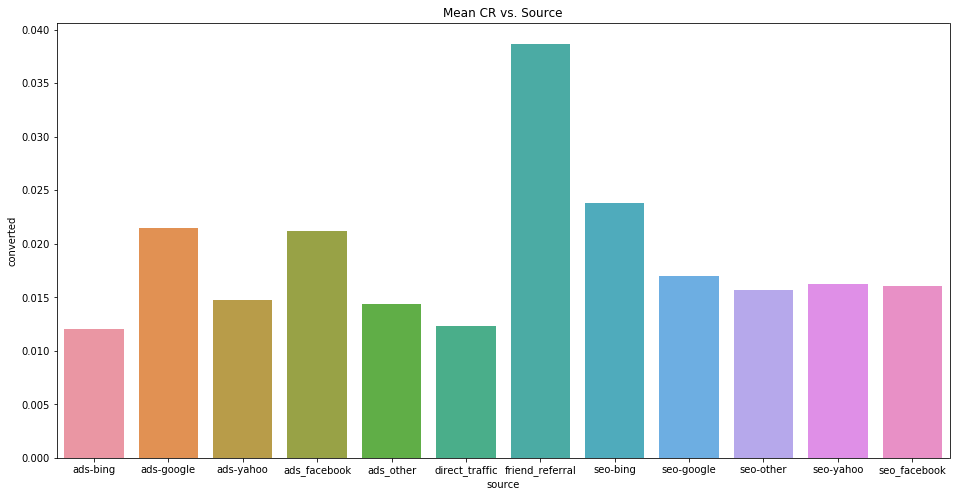

In [45]:
fig, ax = plt.subplots(figsize = (16,8))
sns.barplot(x = 'source', y = 'converted', data = src, ax = ax)
ax.set_title('Mean CR vs. Source', fontsize = 12)
plt.show()

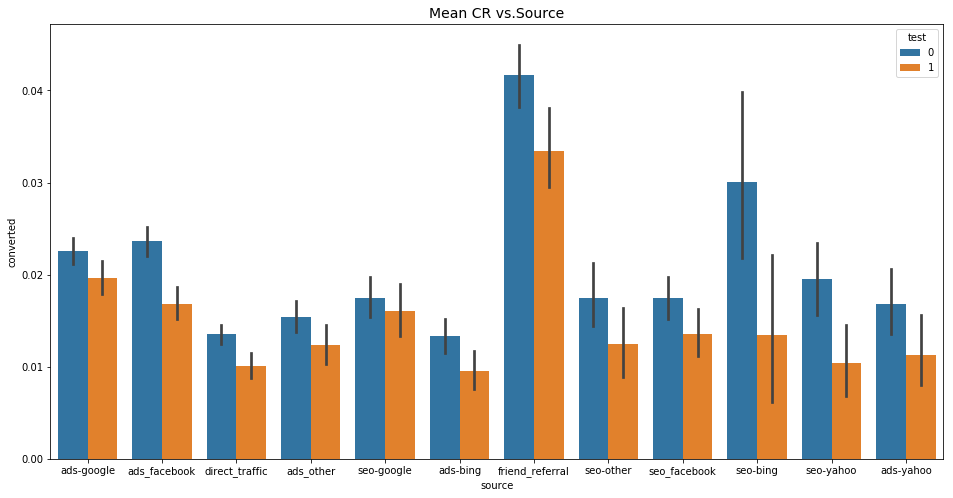

In [35]:
#source visualization with test
fig, ax = plt.subplots(figsize = (16,8))
sns.barplot(x = 'source', y = 'converted', hue = 'test', data = data, ax = ax)
ax.set_title('Mean CR vs.Source', fontsize = 14)
plt.show()

### Device

In [37]:
de = data.groupby('device')['converted'].mean().reset_index()
de

,device,converted
0,mobile,0.018554
1,web,0.018023


Text(0.5,1,'Mean CR vs. device')

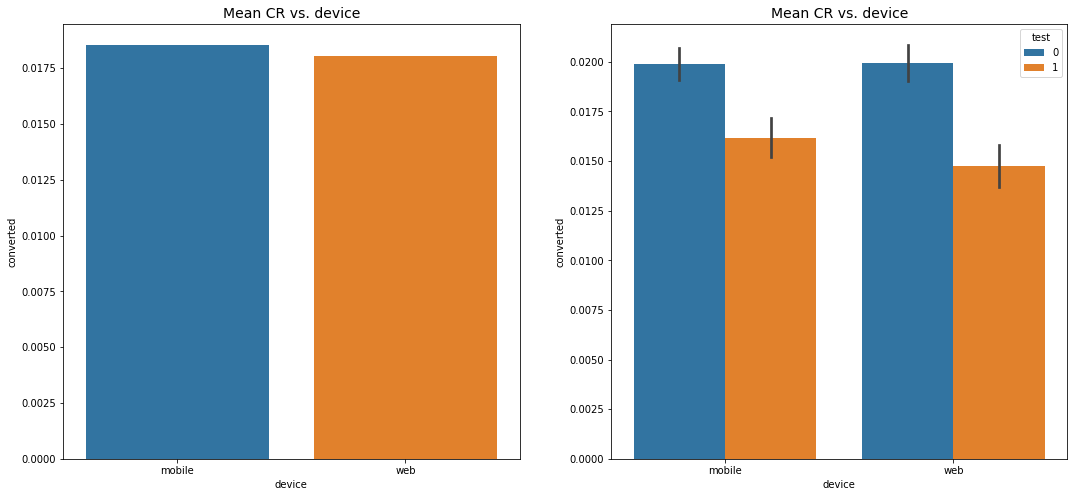

In [39]:
#Visulization
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,8))

sns.barplot(x = 'device', y = 'converted', data = de, ax = ax[0])
ax[0].set_title('Mean CR vs. device', fontsize = 14)

sns.barplot(x = 'device', y ='converted', hue = 'test', data = data, ax = ax[1])
ax[1].set_title('Mean CR vs. device', fontsize = 14)

### OS

In [48]:
os = data.groupby('operative_system')['converted'].mean().reset_index()
os.sort_values(by = 'converted', ascending = False)

,operative_system,converted
3,mac,0.023987
1,iOS,0.022328
5,windows,0.016966
0,android,0.014919
4,other,0.012981
2,linux,0.008232


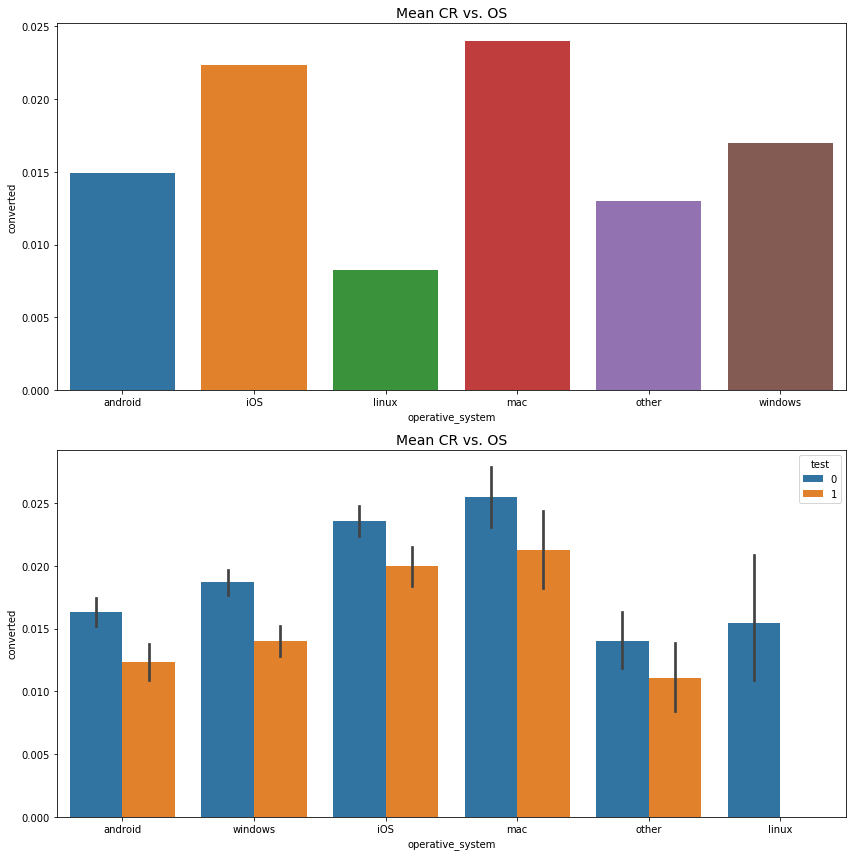

In [50]:
#visulization
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 12))

sns.barplot(x = 'operative_system', y ='converted', data = os, ax = ax[0])
ax[0].set_title('Mean CR vs. OS', fontsize = 14)

sns.barplot(x = 'operative_system', y = 'converted', data = data, hue = 'test', ax = ax[1])
ax[1].set_title('Mean CR vs. OS', fontsize = 14)

plt.tight_layout()
plt.show()


Findings:

Price indeed play a key role in conversion rate. Besides price, there are other factors influence the conversion rate.

* Source
    * fried referal users have higher conversion rate in both control and experimental group users.
* Device
    * The device seems like not a significant factor to the conversion rate.
* Operative System
    * Mac & iOS have higher conversion rate

Insights:
* If we want to increase the price, we should compensate other two factors(device and source)
    * Eg. run promotion to mac/ios users
    * run email refer link with rewards to users who invite others to use the product
* Mean CR in Linux users is far lower than other OS, report to the development team to check the application, if there is any bugs.